# Machine Learning Project

##### Imports

In [43]:
%pylab inline
import scipy.io as sio
from sklearn.neighbors import NearestNeighbors
from sklearn import svm, grid_search
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from glob import glob
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


##### Define some variables

In [27]:
def get_variables(data):
    gX, gY, rX, rY = data["goalx"][-120:], data["goaly"][-120:], data["respx"][-120:], data["respy"][-120:]
    tmpY = gX + gY
    mapper = {val: i for i, val in enumerate(sorted(list(set(tmpY[:,0]))))}
    y = [mapper[Y] for Y in tmpY[:,0]] 
    X = np.hstack((rX, rY))
    vowel_mapper = {1791: "aah", 2548: "ee", 2314: "eh"}
    return X, y, vowel_mapper

##### Define an SVM and grid search over parameters in a cross validation

the predicted y is the cross-validated y

**hyperparameters:**

* C: Penalty parameter C of the error term.
* kernel: linear or rbf 

In [77]:
def run_svm(X,y):
    parameters = {'kernel':('linear', 'rbf'), 'C':[0.001, 0.1, 1, 10, 100]}
    svr = svm.SVC()
    clf = grid_search.GridSearchCV(svr, parameters)
    y_pred = cross_val_predict(clf, X, y)
    return y_pred, clf

##### Plotting functions

In [29]:
def plot_confusion_matrix(cm, mapper, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(mapper.keys()))
    foo = [vowel_mapper[q] for q in sorted(mapper.keys())]
    plt.xticks(tick_marks, foo, rotation=45)
    plt.yticks(tick_marks, foo)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##### Show confusion matrix

In [31]:
def get_confusion_matrix(y,y_pred, mapper, title="Normalized confusion matrix"):
    cm = confusion_matrix(y, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, mapper, title=title)
    return cm_normalized

### Load data and run on every subject

In [36]:
subjects = sorted(glob("s*.mat"))
print subjects

['s10_matfile.mat', 's12_matlfile.mat', 's2_matfile.mat', 's3_matfile.mat', 's4_matfiles.mat', 's5_matfiles.mat', 's6_matfile.mat', 's7_matfile.mat', 's8_matfile.mat', 's9_matfile.mat']


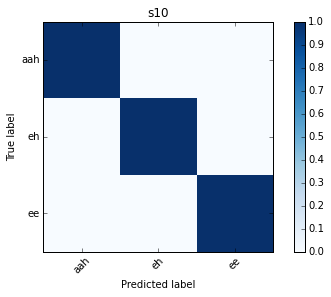

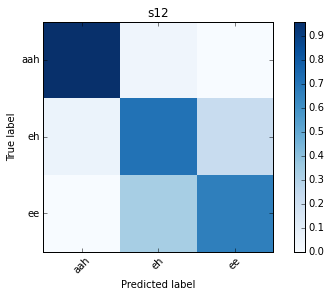

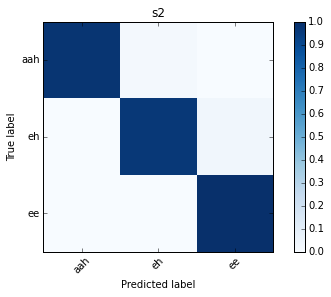

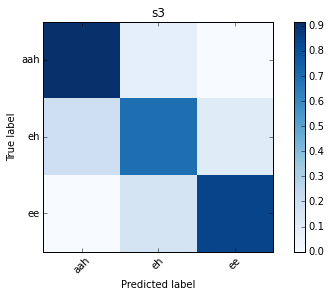

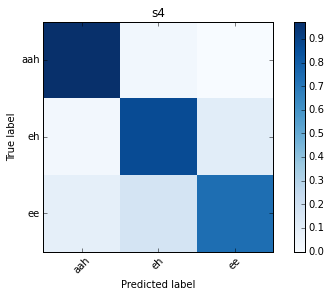

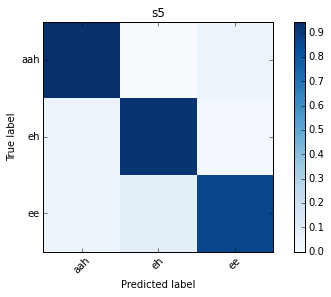

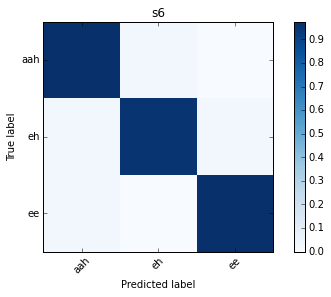

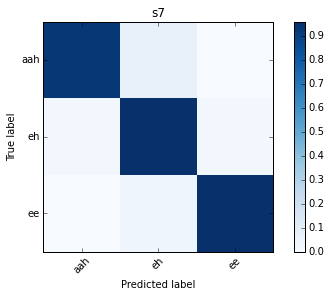

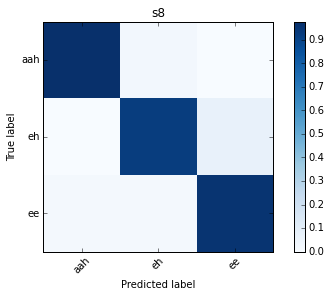

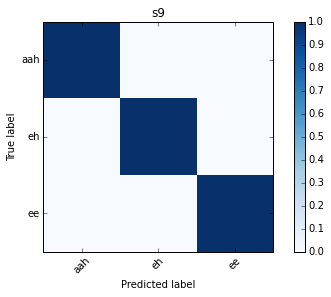

In [74]:
result = {}
hyper_parameters = pd.DataFrame(index = [s.split("_")[0] for s in subjects], columns = ["C", "kernel", 
                                                                                        "ah", "eh", "ee"])
for s in subjects:
    data = sio.loadmat(s)
    X, y, mapper = get_variables(data)
    y_pred, clf = run_svm(X,y)
    subname = s.split("_")[0]
    CM = get_confusion_matrix(y, y_pred, mapper, subname)
    result[subname] = CM
    hyper_parameters["C"].loc[subname] = clf.estimator.C
    hyper_parameters["kernel"].loc[subname] = clf.estimator.kernel
    hyper_parameters["ah"].loc[subname] = CM.diagonal()[0]
    hyper_parameters["eh"].loc[subname] = CM.diagonal()[1]
    hyper_parameters["ee"].loc[subname] = CM.diagonal()[2]

In [76]:
hyper_parameters

,C,kernel,ah,eh,ee
s10,1,rbf,1,1,1
s12,1,rbf,0.9591837,0.7142857,0.6666667
s2,1,rbf,0.9791667,0.9666667,1
s3,1,rbf,0.9166667,0.6956522,0.8421053
s4,1,rbf,0.9722222,0.8684211,0.7391304
s5,1,rbf,0.9444444,0.9268293,0.8604651
s6,1,rbf,0.9736842,0.9534884,0.974359
s7,1,rbf,0.9285714,0.9545455,0.9583333
s8,1,rbf,0.9761905,0.9259259,0.9607843
s9,1,rbf,1,1,1


In [34]:
sio.savemat("SVM_result.mat", result)